In [25]:
import torch
import os
import torch.nn as nn
import torch.optim as om
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from data import CustomImageDataset, transform_train, transform_test  # Importer depuis data.py
from torchvision import models

In [26]:
# Définir les labels
classNames = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

# Charger les fichiers d'images et les labels 
dataDir = "raw-img"  
imageFilesList = []
imageClass = []

for class_index, class_name in enumerate(classNames):
    class_dir = os.path.join(dataDir, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path):
                imageFilesList.append(file_path)
                imageClass.append(class_index)


In [27]:
# Exclure les insectes
exclude_classes = [3, 8]
exclude_class_set = set(exclude_classes)
filtered_indices = [i for i in range(len(imageClass)) if imageClass[i] not in exclude_classes]

filtered_imageFilesList = [imageFilesList[i] for i in filtered_indices]
filtered_imageClass = [imageClass[i] for i in filtered_indices]

In [28]:
# Mapper les indices de classe pour exclure les classes indésirables
class_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted(set(imageClass) - exclude_class_set))}
mapped_imageClass = [class_map[old_idx] for old_idx in filtered_imageClass]

In [29]:
numTotal = len(filtered_imageFilesList)
validFrac = 0.1
testFrac = 0.1
validList = []
testList = []
trainList = []

In [30]:
for i in range(numTotal):
    rann = np.random.random()
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)

In [31]:
trainDataset = CustomImageDataset([filtered_imageFilesList[i] for i in trainList], [mapped_imageClass[i] for i in trainList], transform=transform_train)
validDataset = CustomImageDataset([filtered_imageFilesList[i] for i in validList], [mapped_imageClass[i] for i in validList], transform=transform_test)
testDataset = CustomImageDataset([filtered_imageFilesList[i] for i in testList], [mapped_imageClass[i] for i in testList], transform=transform_test)

In [32]:
batchSize = 64
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=False)


In [33]:
# Définir le modèle CNN ResNet18
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classNames) - len(exclude_classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

c:\Users\utilisateur\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\utilisateur\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# Définir les poids de la perte pour le déséquilibre des classes
filtered_class_counts = np.bincount([mapped_imageClass[i] for i in trainList], minlength=len(class_map))

In [35]:
CEweights = torch.tensor(filtered_class_counts, dtype=torch.float32)
CEweights = 1. / CEweights.clamp_(min=1.)
CEweights = (CEweights * len(classNames) / CEweights.sum()).to(device)

In [37]:
# Initialiser un optimiseur
opti = om.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = om.lr_scheduler.ReduceLROnPlateau(opti, mode='min', patience=3, factor=0.5, verbose=True)


In [38]:
# Entraînement du modèle avec Dropout
maxEpochs = 10
t2vRatio = 1.2
t2vEpochs = 5

train_losses = []
valid_losses = []
best_valid_loss = float('inf')
best_model_path = 'best_model.pt'

for epoch in range(maxEpochs):
    model.train()
    epochLoss = 0.0
    for batX, batY in trainLoader:
        opti.zero_grad()
        batX, batY = batX.to(device), batY.to(device)
        yOut = model(batX)
        loss = F.cross_entropy(yOut, batY, weight=CEweights)
        epochLoss += loss.item()
        loss.backward()
        opti.step()
    epochLoss /= len(trainLoader)
    train_losses.append(epochLoss)
    
    validLoss = 0.0
    model.eval()
    with torch.no_grad():
        for batX, batY in validLoader:
            batX, batY = batX.to(device), batY.to(device)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY, weight=CEweights).item()
    validLoss /= len(validLoader)
    valid_losses.append(validLoss)
    
    print(f"Epoch = {epoch}; Training loss = {epochLoss:.4f}; Validation loss = {validLoss:.4f}")
    
    scheduler.step(validLoss)
    
    if validLoss < best_valid_loss:
        best_valid_loss = validLoss
        torch.save(model.state_dict(), best_model_path)
        t2vEpochs = 5
    else:
        t2vEpochs -= 1
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

Epoch = 0; Training loss = 0.5006; Validation loss = 0.1714
Epoch = 1; Training loss = 0.1855; Validation loss = 0.1330
Epoch = 2; Training loss = 0.1433; Validation loss = 0.1058
Epoch = 3; Training loss = 0.1145; Validation loss = 0.0954
Epoch = 4; Training loss = 0.0947; Validation loss = 0.0885
Epoch = 5; Training loss = 0.0819; Validation loss = 0.0825
Epoch = 6; Training loss = 0.0656; Validation loss = 0.0804
Epoch = 7; Training loss = 0.0549; Validation loss = 0.0738
Epoch = 8; Training loss = 0.0482; Validation loss = 0.0717
Epoch = 9; Training loss = 0.0444; Validation loss = 0.0723


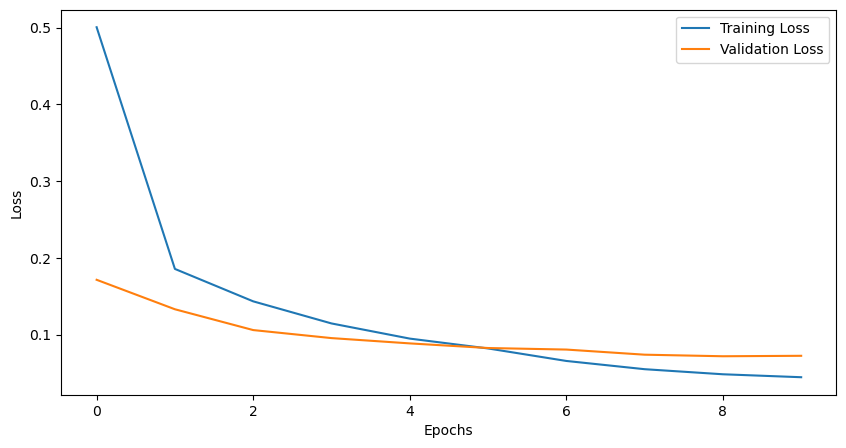

In [39]:
# Visualisation des pertes
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
numClass = len(class_map)
confuseMtx = np.zeros((numClass, numClass), dtype=int)  # Create empty confusion matrix
model.eval()
with torch.no_grad():
    for batX, batY in testLoader:
        batX, batY = batX.to(device), batY.to(device)
        yOut = model(batX)  # Pass test batch through model
        pred = yOut.max(1, keepdim=True)[1]  # Generate predictions by finding the max Y values
        for k in torch.cat((batY.view_as(pred), pred), dim=1).tolist():  # Glue together Actual and Predicted to
            confuseMtx[k[0], k[1]] += 1  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i, i] for i in range(numClass)])  # Sum over diagonal elements to count correct predictions
print("Correct predictions:", correct, "of", len(testDataset))
print((correct / len(testDataset)) * 100)
print("Confusion Matrix:")
print(confuseMtx)
print([classNames[i] for i in range(len(classNames)) if i not in exclude_classes])

Correct predictions: 1902 of 1963
96.89251146204788
Confusion Matrix:
[[461   1   1   2   7   3   1   4]
 [  3 269   0   0   0   5   1   0]
 [  1   0 144   1   0   0   0   0]
 [  0   0   0 286   0   1   1   0]
 [  4   0   0   1 154   0   0   0]
 [  1   5   1   0   0 198   1   0]
 [  3   2   1   1   0   7 177   1]
 [  0   0   0   0   0   0   1 213]]
['cane', 'cavallo', 'elefante', 'gallina', 'gatto', 'mucca', 'pecora', 'scoiattolo']


In [41]:
# Fonction pour redimensionner l'image pour l'affichage
def scaleBack(x):
    x = x.cpu()
    if x.min() < x.max():
        x = (x - x.min()) / (x.max() - x.min())
    return x.permute(1, 2, 0).numpy()

In [42]:
# Charger le modèle entraîné
model.eval()

# Préparer la visualisation
plt.figure(figsize=(10, 10))
imagesLeft = 9

<Figure size 1000x1000 with 0 Axes>

In [43]:
# Permuter les données de test pour les mélanger
permute = torch.randperm(len(testDataset))
testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=False)
test_indices = permute.tolist()

# Collecter des données de test mélangées
testX = torch.stack([testDataset[i][0] for i in test_indices])
testY = torch.tensor([testDataset[i][1] for i in test_indices])


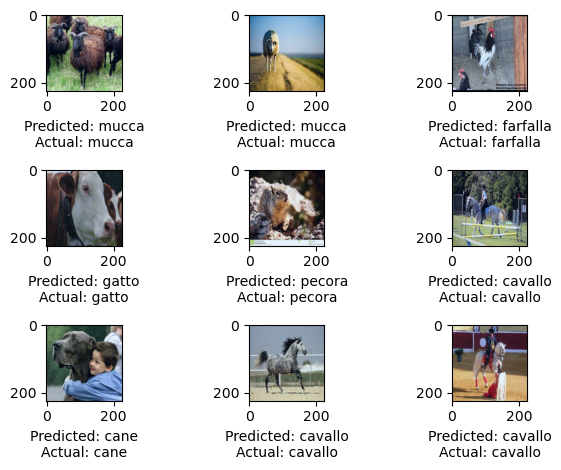

In [44]:
# Itérer sur les batches de test
for j in range(0, len(testX), batchSize):
    batX = testX[j:j + batchSize].to(device)
    batY = testY[j:j + batchSize].to(device)
    yOut = model(batX)  # Passer le batch de test à travers le modèle
    pred = yOut.argmax(dim=1)  # Générer les prédictions en trouvant les valeurs Y maximales

    for i in range(len(batX)):
        if imagesLeft and batY[i].item() == pred[i].item():  # Comparer la valeur y réelle à la prédiction
            imagesLeft -= 1
            plt.subplot(3, 3, 9 - imagesLeft)
            plt.xlabel(f"Predicted: {classNames[pred[i].item()]}\nActual: {classNames[batY[i].item()]}")
            plt.imshow(scaleBack(batX[i]), cmap='gray', vmin=0, vmax=1)

    if imagesLeft == 0:
        break

plt.tight_layout()
plt.show()

In [45]:
pwd

'c:\\Users\\utilisateur\\Documents\\SIMPLONS\\E1\\Nouveau dossier'

In [46]:
ls

 Le volume dans le lecteur C s'appelle Windows
 Le num�ro de s�rie du volume est 7296-1F96

 R�pertoire de c:\Users\utilisateur\Documents\SIMPLONS\E1\Nouveau dossier

24/05/2024  15:08    <DIR>          .
24/05/2024  15:08    <DIR>          ..
23/05/2024  14:05    <DIR>          __pycache__
24/05/2024  14:07           973�544 Analyse_exploratoire.ipynb
24/05/2024  14:04         1�765�376 animaux.db
24/05/2024  14:04               700 bdd_relationnelle.py
25/05/2024  15:08        44�799�489 best_model.pt
23/05/2024  14:05             1�156 data.py
24/05/2024  14:03         1�572�325 donnees_animaux.csv
25/05/2024  15:58           246�044 model.ipynb
21/05/2024  16:49    <DIR>          raw-img
22/05/2024  07:35                59 requirements.txt
23/05/2024  10:19         2�656�342 test.ipynb
12/12/2019  20:50               380 translate.py
              10 fichier(s)       52�015�415 octets
               4 R�p(s)  63�762�751�488 octets libres


In [47]:
import torch
torch.save(model, 'saved_model')